In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch_scatter as scatter
import yaml
from models.sc_net import SCnet,GNN,CoordiNet
import sys
import torch.nn.functional as F
import copy
sys.path.append('..')
from torch.nn import Sequential as Seq, Linear, ReLU,Parameter
from dataset.tmQM_data import tmQM_wrapper,tmQM_dataset
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
import torch_geometric.nn as nn

c:\Users\admin\Anaconda3\envs\PyG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = yaml.load(open("./config.yaml", "r"), Loader=yaml.FullLoader)

In [3]:
dataset = tmQM_wrapper(config['path'],config['batch_size'],separated=config['separated'],**config['data'])
train,valid,test = dataset.get_data_loaders()

ERROR SAMPLE:GEJBUS
ERROR SAMPLE:OKAPEX


In [4]:
model = SCnet(
    GNN_config=config['GNN'],
    Coor_config=config['Coor_config'],
    out_dimention=config['out_dimention'],
    separated=config['separated'],
)
model1 = GNN(**config['GNN'])
model2 = CoordiNet(**config['Coor_config'])

AttributeError: 'CoordiNet' object has no attribute 'pool'

In [10]:
iteration = iter(train)
BatchData = next(iteration)
x = BatchData.x
batch = BatchData.batch
index = BatchData.edge_index
metal = BatchData.metal

In [2]:
import matplotlib.pyplot as plt

In [3]:
mean = np.array([2948.5,0.14095,5.7493,0.15659,0.10936,0.19877,0.089408,393.36])
std = np.array([1624.2,0.069491,3.8897,0.79056,0.03385,0.054267,0.055114,151.05])

In [15]:
path = './experiment/entire/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
ent_mean = np.average(data/mean,axis=0)
ent_std = np.std(data/mean,axis=0)

In [16]:
path = './experiment/diffpool-32/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
diff32_mean = np.average(data/mean,axis=0)
diff32_std = np.std(data/mean,axis=0)

In [17]:
path = './experiment/NoAttention/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
noa_mean = np.average(data/mean,axis=0)
noa_std = np.std(data/mean,axis=0)

In [18]:
path = './experiment/No-atten-metal/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
noam_mean = np.average(data/mean,axis=0)
noam_std = np.std(data/mean,axis=0)

In [22]:
x = np.array(list(range(1,9)))

<ErrorbarContainer object of 3 artists>

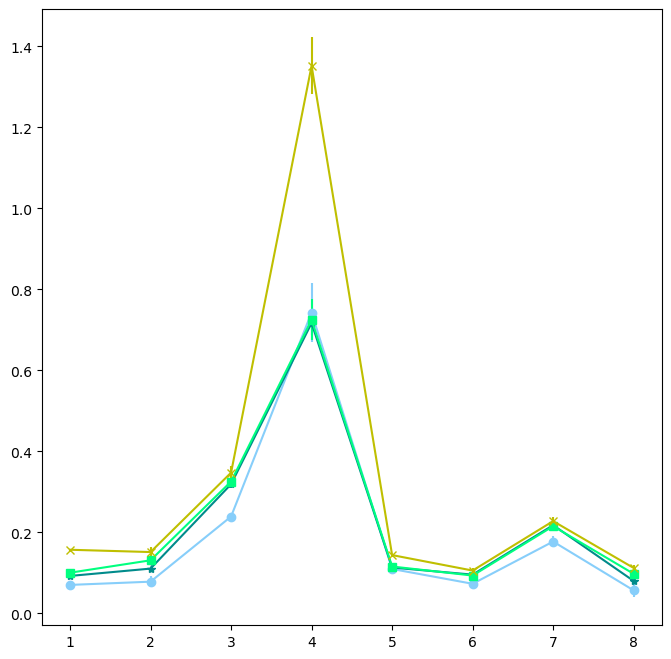

In [34]:
fig = plt.figure(figsize=(8,8))
plt.errorbar(x,ent_mean,ent_std,ecolor='lightskyblue',fmt='-o',color='lightskyblue')
plt.errorbar(x,diff32_mean,diff32_std,ecolor='darkcyan',fmt='-*',color='darkcyan')
plt.errorbar(x,noa_mean,noa_std,ecolor='springgreen',fmt='-s',color='springgreen')
plt.errorbar(x,noam_mean,noam_std,ecolor='y',fmt='-x',color='y')

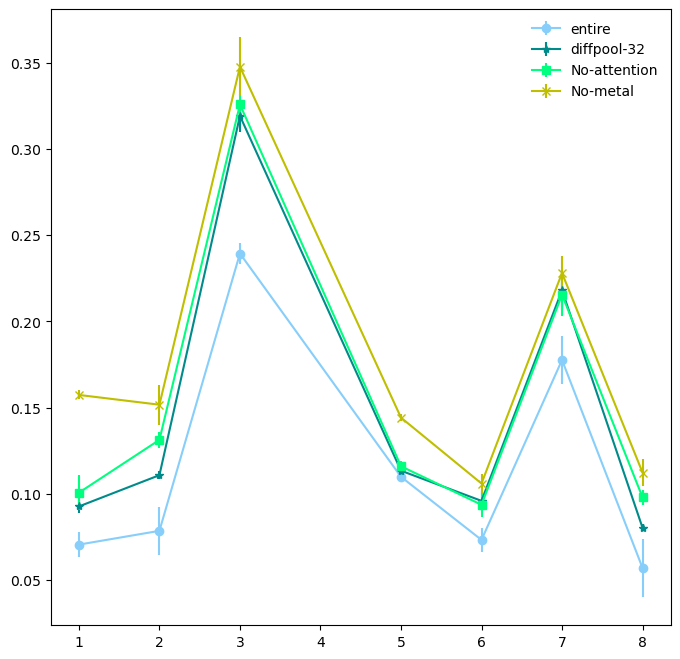

In [38]:
fig = plt.figure(figsize=(8,8))
x = np.array([1,2,3,5,6,7,8])
plt.errorbar(x,ent_mean[x-1],ent_std[x-1],ecolor='lightskyblue',fmt='-o',color='lightskyblue',label='entire')
plt.errorbar(x,diff32_mean[x-1],diff32_std[x-1],ecolor='darkcyan',fmt='-*',color='darkcyan',label='diffpool-32')
plt.errorbar(x,noa_mean[x-1],noa_std[x-1],ecolor='springgreen',fmt='-s',color='springgreen',label='No-attention')
plt.errorbar(x,noam_mean[x-1],noam_std[x-1],ecolor='y',fmt='-x',color='y',label='No-metal')
plt.legend(frameon=False)

In [47]:
path = './experiment/diffpool_16/result.csv'
data = pd.read_csv(path,index_col=0).to_numpy()
diff16_mean = data[5,:]/mean
diff16_std = data[6,:]/mean

In [49]:
path = './experiment/diffpool_64/result.csv'
data = pd.read_csv(path,index_col=0).to_numpy()
diff64_mean = data[5,:]/mean
diff64_std = data[6,:]/mean

In [50]:
path = './experiment/topk-0.5/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
topk_mean = np.average(data/mean,axis=0)
topk_std = np.std(data/mean,axis=0)

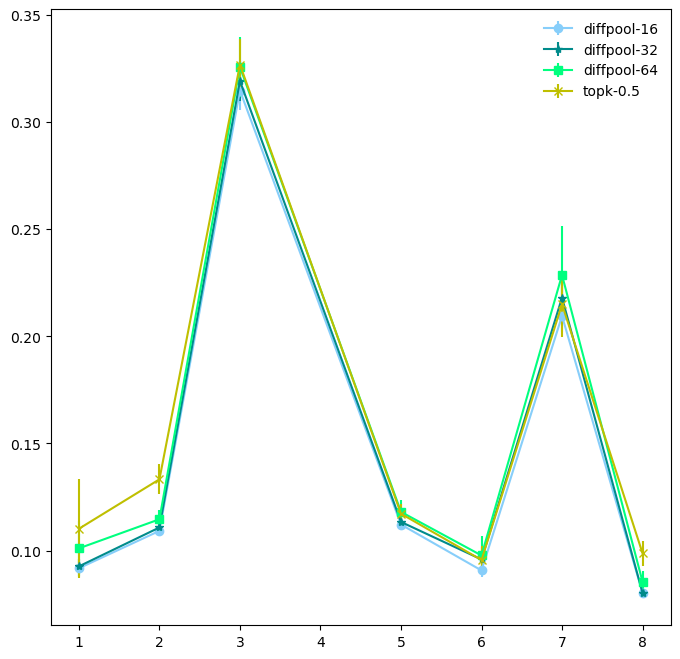

In [51]:
fig = plt.figure(figsize=(8,8))
x = np.array([1,2,3,5,6,7,8])
plt.errorbar(x,diff16_mean[x-1],diff16_std[x-1],ecolor='lightskyblue',fmt='-o',color='lightskyblue',label='diffpool-16')
plt.errorbar(x,diff32_mean[x-1],diff32_std[x-1],ecolor='darkcyan',fmt='-*',color='darkcyan',label='diffpool-32')
plt.errorbar(x,diff64_mean[x-1],diff64_std[x-1],ecolor='springgreen',fmt='-s',color='springgreen',label='diffpool-64')
plt.errorbar(x,topk_mean[x-1],topk_std[x-1],ecolor='y',fmt='-x',color='y',label='topk-0.5')
plt.legend(frameon=False)

In [73]:
for i in [0.2,0.4,0.6]:
    path = f'./experiment/trainNoA_{str(i)}/result.csv'
    data = pd.read_csv(path,index_col=0).to_numpy()
    temp_mean = data[5,:]/mean
    temp_std = data[6,:]/mean
    if i == 0.2:
        trainNoa_mean = temp_mean[np.newaxis,:]
        trainNoa_std = temp_std[np.newaxis,:]
    else:
        trainNoa_mean = np.append(trainNoa_mean,temp_mean[np.newaxis,:],axis=0)
        trainNoa_std = np.append(trainNoa_std,temp_std[np.newaxis,:],axis=0)
path = './experiment/NoAttention/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
temp_mean = np.average(data/mean,axis=0)
temp_std = np.std(data/mean,axis=0)
trainNoa_mean = np.append(trainNoa_mean,temp_mean[np.newaxis,:],axis=0)
trainNoa_std = np.append(trainNoa_std,temp_std[np.newaxis,:],axis=0)

In [77]:
for i in [0.2,0.4,0.6]:
    path = f'./experiment/trainAtt_{str(i)}/result.csv'
    data = pd.read_csv(path,index_col=0).to_numpy()
    temp_mean = data[5,:]/mean
    temp_std = data[6,:]/mean
    if i == 0.2:
        trainAtt_mean = temp_mean[np.newaxis,:]
        trainAtt_std = temp_std[np.newaxis,:]
    else:
        trainAtt_mean = np.append(trainAtt_mean,temp_mean[np.newaxis,:],axis=0)
        trainAtt_std = np.append(trainAtt_std,temp_std[np.newaxis,:],axis=0)
path = './experiment/diffpool-32/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
temp_mean = np.average(data/mean,axis=0)
temp_std = np.std(data/mean,axis=0)
trainAtt_mean = np.append(trainAtt_mean,temp_mean[np.newaxis,:],axis=0)
trainAtt_std = np.append(trainAtt_std,temp_std[np.newaxis,:],axis=0)

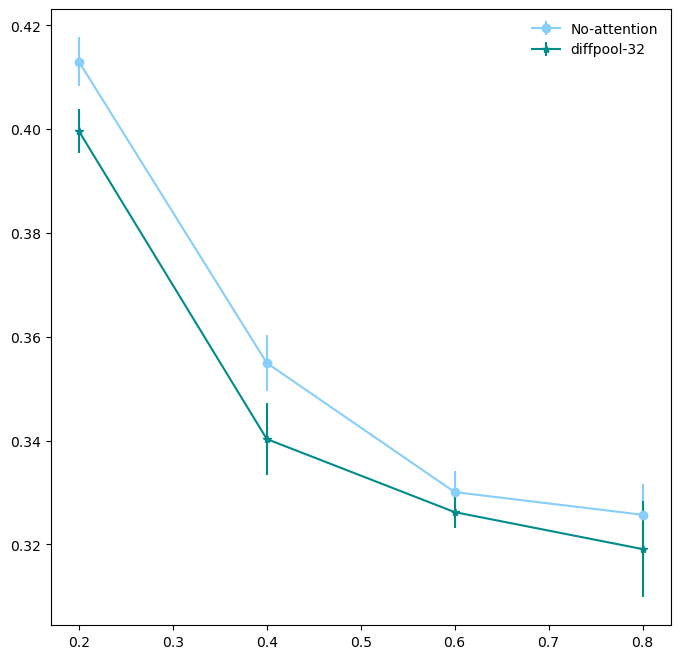

In [82]:
fig = plt.figure(figsize=(8,8))
target = 2
x = np.array([0.2,0.4,0.6,0.8])
plt.errorbar(x,trainNoa_mean[:,target],trainNoa_std[:,target],ecolor='lightskyblue',fmt='-o',color='lightskyblue',label='No-attention')
plt.errorbar(x,trainAtt_mean[:,target],trainAtt_std[:,target],ecolor='darkcyan',fmt='-*',color='darkcyan',label='diffpool-32')
plt.legend(frameon=False)